## LC Model Search Framework

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [75]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [93]:
exp_name = 'simple_keras_tests'
model_name = 'rnn_lstm'

Assign your specific GPU so we don't overlap

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";

Is that GPU and only that GPU visible?

Note that it will always say GPU:0 but you should just see one

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [6]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [7]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [8]:
train_gdf = gpd.read_file('../train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((81, 3543), '028012'))

In [12]:
val_gdf = gpd.read_file('../val_buffered_points140520.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    #if not row['dubious']:
        total_per_class_count[int(row['label'])] = total_per_class_count[int(row['label'])] + 1
        if per_class_count[int(row['label'])] < 125:
            per_class_count[int(row['label'])] = per_class_count[int(row['label'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(750, ((2678, 1318), '028011'))

In [13]:
total_per_class_count, per_class_count

([150, 150, 150, 150, 150, 150], [125, 125, 125, 125, 125, 125])

In [14]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,geometry
0,0.0,596,0,698,029011,1802310.0,1643850.0,"POLYGON ((-75.6441512084 36.10119086803808, -7..."
1,0.0,467,0,3956,029011,1798440.0,1546110.0,POLYGON ((-75.91635673586633 35.25513889890946...
2,0.0,749,0,4096,029011,1806900.0,1541910.0,POLYGON ((-75.83449049734953 35.20255815179633...
3,0.0,4780,0,4536,028011,1777830.0,1528710.0,POLYGON ((-76.17979015822588 35.14144967077146...
4,0.0,1120,0,3425,028012,1668030.0,1412040.0,"POLYGON ((-77.6206367137414 34.31532226132933,..."


### Create the RNN

In [99]:
def strangeBlock_v4(input_block, nb_layers, filters):
    x_list = [input_block]
    c_temp = input_block
    for i in range(nb_layers):
        c_l = LSTM(units=filters, activation='elu', return_sequences=True) (c_temp)
        x_list.append(c_l)
        merge = Concatenate()(x_list)
        c_temp = merge
    return c_temp

In [12]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=False)(first_pool3D)
    
    first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer3)
    
    third_batch_norm = BatchNormalization()(first_pool2D)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])
    
    concat = flatten
    
    denselayer = Dense(64, activation="elu")(concat)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [13]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    
    
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(input_tensor_tile)
    
    first_batch_norm = BatchNormalization()(cnn_layer1)
    
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_batch_norm)
    
    second_batch_norm = BatchNormalization()(cnn_layer2)
    
    first_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(second_batch_norm)
    
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', data_format='channels_last', 
                            return_sequences=True)(first_pool3D)
    
    third_batch_norm = BatchNormalization()(cnn_layer3)
    
    #first_pool2D = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (third_batch_norm)
    #second_pool3D = MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last')(third_batch_norm)
    
    flatten = Flatten()(third_batch_norm)
    
    #concat = concatenate([final_block, flatten])    
    denselayer = Dense(64, activation="elu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [14]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last')(input_tensor_tile)
    first_batch_norm = BatchNormalization()(cnn_layer1)
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True, data_format='channels_last') (first_batch_norm)
    second_batch_norm = BatchNormalization()(cnn_layer2)
    maxpool = MaxPooling3D(pool_size=(1, 2, 2), strides=None, padding='same') (second_batch_norm)
    cnn_layer3 = ConvLSTM2D(64, kernel_size=2, activation='elu', return_sequences=False, data_format='channels_last') (second_batch_norm)
    flatten = Flatten()(cnn_layer3)
    #concat = concatenate([final_block, flatten])
    
    denselayer = Dense(64, activation="relu")(flatten)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

In [94]:
def make_MLT_dense(in_shape, in_shape_tile, num_classes):
    input_tensor = Input(shape = in_shape, name="rnn_input")
    #single pixel rnn model
    block = strangeBlock_v4(input_tensor, 5, 12)
    block_2 = strangeBlock_v4(block, 3, 20)
    final_block = LSTM(64, activation='softmax', return_sequences=False) (block_2)

    #cnn model
    input_tensor_tile = Input(shape = in_shape_tile, name="tile_input")
    cnn_layer1 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=True)(input_tensor_tile)
    # batch norm
    cnn_layer2 = ConvLSTM2D(64, kernel_size=3, activation='elu', return_sequences=False) (cnn_layer1)
    maxpool = MaxPooling2D(pool_size=(2, 2), strides=None, padding='same') (cnn_layer2)
    flatten = Flatten()(maxpool)
    concat = concatenate([final_block, flatten])
    
    #denselayer = Dense(64, activation="elu")(concat)
    denselayer = Dense(64, activation="elu")(final_block)
    
    landcover = Dense(num_classes,activation='softmax', name='landcover') (denselayer)
    #canopy = Dense(1, name='canopy') (concat)

    model = Model(inputs=[input_tensor,input_tensor_tile], outputs=[landcover])
    return model

Start the experiments here:

In [95]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.7 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/dd3823336ba440d686fac61999bef6d0



In [96]:
experiment.add_tag(exp_name)

In [97]:
tile_size = 13
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 60
batch_size = 25
steps_division_factor = 10

In [18]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=((tile_size*tile_size*len(tiles['028012'])*7),)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                378624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 383,174
Trainable params: 383,174
Non-trainable par

In [72]:
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=(len(tiles['028012']),tile_size,tile_size,7)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 3, 11, 11, 32)     6080      
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 1, 9, 9, 64)       55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 4, 4, 64)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 4, 4, 64)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [100]:
model = make_MLT_dense((len(tiles['028012']),7),(len(tiles['028012']),tile_size,tile_size,7), class_count)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          (None, 5, 7)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 12)        960         rnn_input[0][0]                  
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 5, 19)        0           rnn_input[0][0]                  
                                                                 lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 5, 12)        1536        concatenate_1[0][0]        

#### Train the Model

In [101]:
filepath = 'model_search/' +  model_name + '--' + exp_name + '.hdf5' #your filepath here
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

In [102]:
model.compile(optimizer=Adam(), loss={'landcover':'categorical_crossentropy'}, metrics={'landcover':['accuracy']}, loss_weights={"landcover":1})

In [103]:
train_time_start = datetime.datetime.now()

history = model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size, flatten=True, canopy=True), 
                steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
                validation_data=tile_gen.tile_generator(val_px, batch_size, flatten=True, canopy=True),
                validation_steps=len(val_px) // batch_size,
                callbacks=callbacks_list) 

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start

Epoch 1/60
36/36 [==============================] - 10s 272ms/step - loss: 1.7710 - acc: 0.2422 - val_loss: 1.7205 - val_acc: 0.4520

Epoch 00001: val_acc improved from -inf to 0.45200, saving model to model_search/rnn_lstm--simple_keras_tests.hdf5
Epoch 2/60
36/36 [==============================] - 4s 115ms/step - loss: 1.6185 - acc: 0.5433 - val_loss: 1.4757 - val_acc: 0.6147

Epoch 00002: val_acc improved from 0.45200 to 0.61467, saving model to model_search/rnn_lstm--simple_keras_tests.hdf5
Epoch 3/60
36/36 [==============================] - 5s 129ms/step - loss: 1.3278 - acc: 0.6278 - val_loss: 1.1833 - val_acc: 0.6227

Epoch 00003: val_acc improved from 0.61467 to 0.62267, saving model to model_search/rnn_lstm--simple_keras_tests.hdf5
Epoch 4/60
36/36 [==============================] - 5s 130ms/step - loss: 1.1116 - acc: 0.5967 - val_loss: 0.9412 - val_acc: 0.6827

Epoch 00004: val_acc improved from 0.62267 to 0.68267, saving model to model_search/rnn_lstm--simple_keras_tests.hdf

36/36 [==============================] - 5s 130ms/step - loss: 0.3662 - acc: 0.8889 - val_loss: 0.2892 - val_acc: 0.9160

Epoch 00041: val_acc did not improve from 0.91867
Epoch 42/60
36/36 [==============================] - 5s 132ms/step - loss: 0.3876 - acc: 0.8733 - val_loss: 0.2854 - val_acc: 0.9040

Epoch 00042: val_acc did not improve from 0.91867
Epoch 43/60
36/36 [==============================] - 5s 127ms/step - loss: 0.3132 - acc: 0.9144 - val_loss: 0.2783 - val_acc: 0.9160

Epoch 00043: val_acc did not improve from 0.91867
Epoch 44/60
36/36 [==============================] - 5s 130ms/step - loss: 0.3384 - acc: 0.8933 - val_loss: 0.2687 - val_acc: 0.9107

Epoch 00044: val_acc did not improve from 0.91867
Epoch 45/60
36/36 [==============================] - 5s 131ms/step - loss: 0.3241 - acc: 0.8867 - val_loss: 0.2875 - val_acc: 0.9133

Epoch 00045: val_acc did not improve from 0.91867
Epoch 46/60
36/36 [==============================] - 5s 131ms/step - loss: 0.3445 - acc: 0.8

dict_keys(['val_loss', 'val_acc', 'acc', 'loss'])


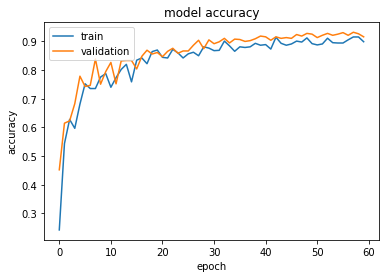

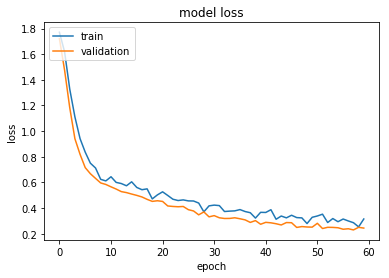

In [104]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_acc")
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
experiment.log_figure(figure=plt, figure_name="model_loss")
plt.show()

In [105]:
filepath

'model_search/rnn_lstm--simple_keras_tests.hdf5'

In [106]:
model = keras.models.load_model(filepath)

# Evaluate model

In [108]:
inference_time_start = datetime.datetime.now()

predictions = model.predict_generator(generator = tile_gen.tile_generator(val_px, batch_size=50, flatten=True, canopy=True), steps=len(val_px) // 50, verbose=1)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start

eval_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)

15/15 [==============================] - 3s 183ms/step


In [109]:
predictions.shape

(750, 6)

In [110]:
lc_predictions = predictions

In [111]:
lc_lab = np.empty(lc_predictions.shape[0])
#canopy_true = np.empty(canopy_pred.shape)
count = 0
while count < len(lc_predictions):
        image_b, label_b = next(eval_generator)
        #print(label_b.shape)
        #label_b = np.argmax(label_b, axis=-1)
        #print(label_b)
        label_b = np.argmax(label_b['landcover'], axis=-1)
        #canopy_true[count] = label_b['canopy']
        lc_lab[count] = label_b
        count += 1
label_index = lc_lab
pred_index = np.argmax(lc_predictions, axis=-1)

Accuracy is 0.932
per_class_acc 0.984
per_class_acc 0.88
per_class_acc 0.96
per_class_acc 0.96
per_class_acc 0.888
per_class_acc 0.92


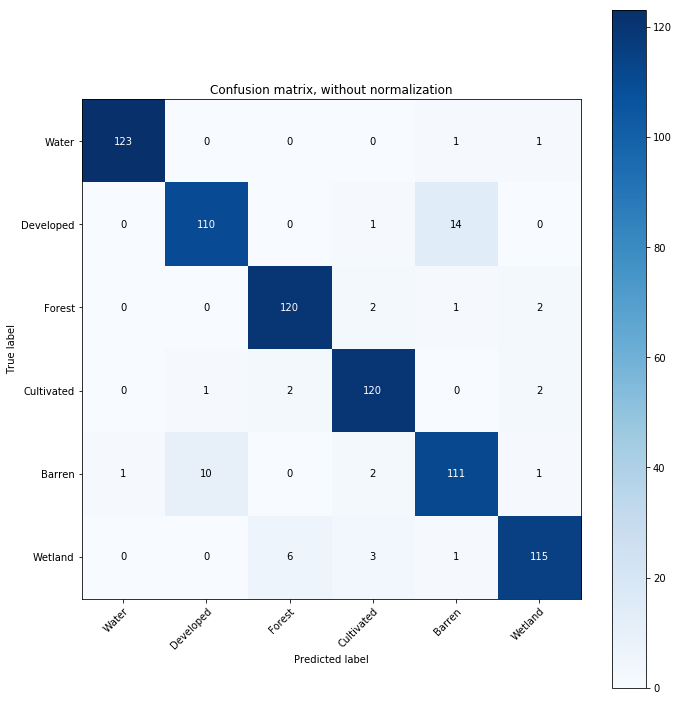

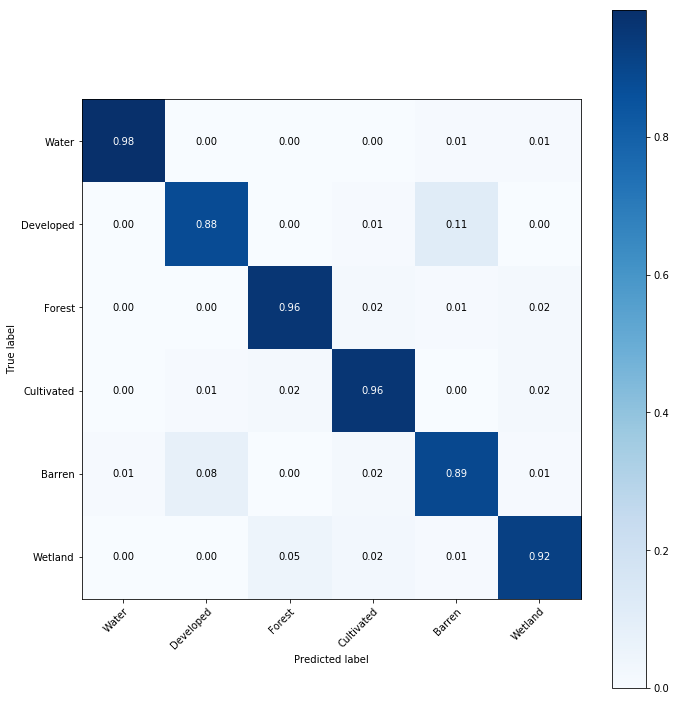

In [112]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix")
# Plot normalized confusion matrix
util.plot_confusion_matrix(label_index.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)),
                      class_dict=class_dict,
                      normalize=True,
                          title=" ")
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix")
count = 0
per_class_acc = [0] * 6
for i in range(len(label_index)):
    if(label_index[i] == pred_index[i]):
        per_class_acc[int(label_index[i])] = per_class_acc[int(label_index[i])] + 1
        count+=1

val_accuracy=count/len(label_index)
class_acc_dict = {}
print("Accuracy is",val_accuracy)
# this is producer's accuracy
for idx, class_correct in enumerate(per_class_acc):
    class_acc_dict[class_dict[idx]] = round(class_correct/(int(len(label_index)/class_count)),4)
    print('per_class_acc', class_correct/(per_class_count[idx]))

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [113]:
import pandas as pd
import seaborn as sns

experiment_df = pd.DataFrame(columns=['exp_name','model_name','time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [114]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [115]:
experiment_df.tail(5)

,exp_name,model_name,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,water_acc_prod,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,simple_keras_tests,rnn_lstm,5,1500.0,0.932,60,13,00:04:58.983485,00:00:02.746320,0.984,...,0.96,0.96,0.888,0.92,0.992,0.909,0.938,0.938,0.867,0.95


In [116]:
experiment_df.to_csv('model_search/' + model_name + '--' + exp_name + '.csv')

In [117]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [118]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "batch_size":batch_size,
    "steps_division_factor":steps_division_factor,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [119]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/dd3823336ba440d686fac61999bef6d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     acc [60]                  : (0.24222222218910852, 0.9155555549595091)
COMET INFO:     batch_acc [240]           : (0.03999999910593033, 1.0)
COMET INFO:     batch_loss [240]          : (0.059985410422086716, 1.7935295104980469)
COMET INFO:     epoch_duration [60]       : (4.24754629295785, 12.398673918913119)
COMET INFO:     loss [60]                 : (0.25383393600996995, 1.7709589004516602)
COMET INFO:     val_acc [60]              : (0.4520000000794729, 0.9319999953111012)
COMET INFO:     val_loss [60]             : (0.23015458757678667, 1.7204827706019084)
COMET INFO:     validate_batch_acc [180]  : (0.3199999928474426, 1.0)
COMET INFO: